## Download and Import

In [1]:
!pip install librosa
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2

In [20]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F

In [6]:
DATASET_PATH = "data/LivingRoom_preprocessed_hack"

In [ ]:
# Define the custom dataset
dataset = CustomDataset(preprocessed_data_mfcc, centroids, preprocessed_data_rms, preprocessed_data_zcr)

# Access a sample from the dataset
mfcc_list, coordinates = dataset[1]
print("MFCC List Length:", len(mfcc_list))
print("MFCC Shape (Microphone 1):", mfcc_list[0].shape)
print("MFCC Shape (Microphone 2):", mfcc_list[1].shape)
print("MFCC Shape (Microphone 3):", mfcc_list[2].shape)
print("MFCC Shape (Microphone 4):", mfcc_list[3].shape)
print("Coordinates:", coordinates)

RMS List Length: 4
RMS Shape (Microphone 1): torch.Size([1, 473])
RMS Shape (Microphone 2): torch.Size([1, 473])
RMS Shape (Microphone 3): torch.Size([1, 473])
RMS Shape (Microphone 4): torch.Size([1, 473])
Coordinates: tensor([-3198.5410,  -744.5101])


## Download Dataset

In [7]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [8]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [9]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [10]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [12]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

## Read Data

In [22]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [23]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)
print(centroids_h1.shape)
print(centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)
(1000, 2)
(104, 2)
[[-3231.3293467  -1127.87771457]
 [-3198.54107875  -744.5100656 ]
 [-3192.9776274   -248.26678827]
 ...
 [-1717.89923578 -3166.59648491]
 [-1808.60337549 -2779.13038427]
 [   44.43741322   106.48353609]]


In [24]:
# Function to normalize coordinates
def normalize_coordinates(centroids):
    # Define the room dimensions
    x_min = -4000
    x_max = 500
    y_min = -4000
    y_max = 2000

    # Calculate the width and height of the room
    room_width = x_max - x_min
    room_height = y_max - y_min

    centroids[:, 0] = (centroids[:, 0] - x_min) / room_width
    centroids_h1[:, 1] = (centroids_h1[:, 1] - y_min) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## Visualize Data

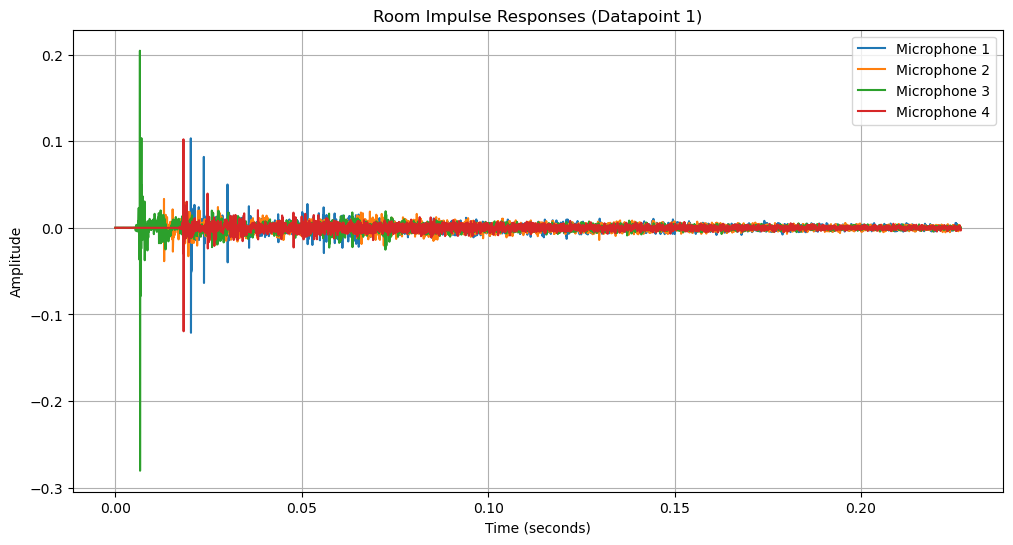

In [26]:
N_datapoints, N_Microphones, N_samples = deconvoled_trim_h1.shape

datapoint_index = 1  # Choose the datapoint index
time_sample_start = 0  # Start index of time samples
time_sample_end = 10000  # End index of time samples (or choose a specific range)

sampling_rate = 44100
time_axis = np.arange(time_sample_end - time_sample_start) / sampling_rate

# Plot the RIRs for each microphone channel
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim_h1[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Plot the RIR on the same figure with different colors for each microphone
    plt.plot(time_axis, rir, label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


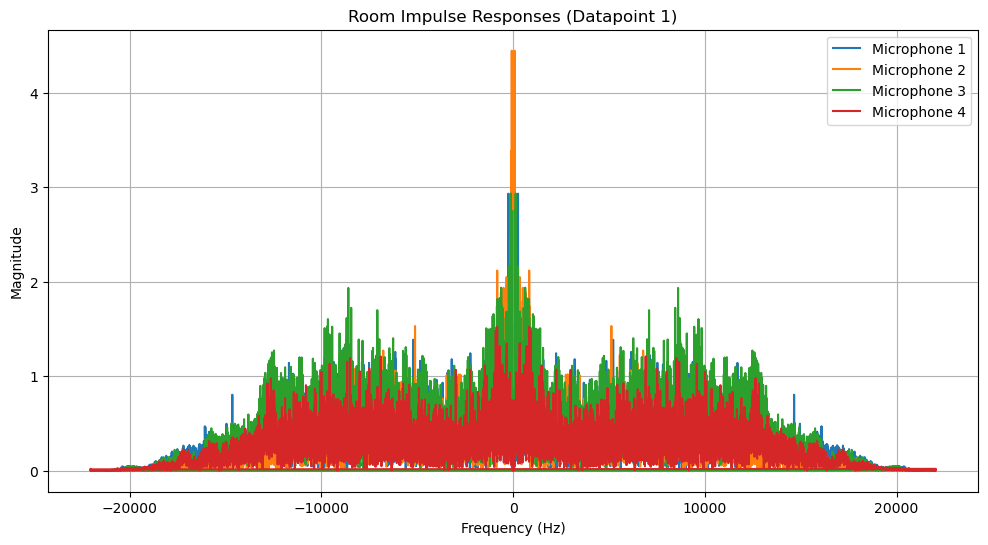

In [27]:
# Plot the RIRs for each microphone channel in the frequency domain
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim_h1[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Compute the FFT
    rir_fft = np.fft.fft(rir)
    
    # Compute the frequency axis
    freq_axis = np.fft.fftfreq(len(rir), 1 / sampling_rate)
    
    # Plot the magnitude of the FFT (absolute value)
    plt.plot(freq_axis, np.abs(rir_fft), label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()

## Preprocessing Data

### Human 1

In [29]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

# Wrap the outer loop with tqdm for progress visualization
for instance_index in tqdm(range(deconvoled_trim_h1.shape[0])):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim_h1.shape[1]):
        # Filtering
        filtered_signal = signal.medfilt(deconvoled_trim_h1[instance_index, channel_index, :], kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)

        #Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction
        # MFCC features
        mfcc_features = librosa.feature.mfcc(y=resampled_signal, sr=16000, n_mfcc=13)

        # RMS features
        rms_features = np.sqrt(np.mean(resampled_signal**2))
        # rms_features = librosa.feature.rms(y=normalized_signal)

        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc_h1 = np.array(preprocessed_data_mfcc)
preprocessed_data_rms_h1 = np.array(preprocessed_data_rms)
preprocessed_data_zcr_h1 = np.array(preprocessed_data_zcr)

100%|██████████| 1000/1000 [04:12<00:00,  3.95it/s]


### Human 2

In [31]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

# Wrap the outer loop with tqdm for progress visualization
for instance_index in tqdm(range(deconvoled_trim_h2.shape[0])):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim_h2.shape[1]):
        # Filtering
        filtered_signal = signal.medfilt(deconvoled_trim_h2[instance_index, channel_index, :], kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)

        # Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction
        # MFCC features
        mfcc_features = librosa.feature.mfcc(y=resampled_signal, sr=16000, n_mfcc=13)

        # RMS features
        rms_features = np.sqrt(np.mean(resampled_signal**2))
        # rms_features = librosa.feature.rms(y=normalized_signal)

        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc_h2 = np.array(preprocessed_data_mfcc)
preprocessed_data_rms_h2 = np.array(preprocessed_data_rms)
preprocessed_data_zcr_h2 = np.array(preprocessed_data_zcr)

100%|██████████| 104/104 [00:21<00:00,  4.89it/s]


In [43]:
def plot_audio_features(instance_index, channel_index, mfcc_features=[], rms_features=[], zero_crossing_rate=[]):
    if len(mfcc_features) > 0:
        # Plot MFCC features
        plt.figure(figsize=(10, 4))
        plt.imshow(mfcc_features, cmap='viridis', origin='lower', aspect='auto')
        plt.xlabel('Frame')
        plt.ylabel('MFCC Coefficient')
        plt.title('MFCC Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
        plt.colorbar(label='Magnitude')
        plt.tight_layout()
        plt.show()

    if len(rms_features) > 0:
        # Plot RMS Features for each channel
        for i, rms_channel in enumerate(rms_features):
            plt.figure(figsize=(10, 4))
            plt.plot(rms_channel, label=f'RMS Features (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('RMS Energy')
            plt.title('RMS Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

    if len(zero_crossing_rate) > 0:
        # Plot Zero-Crossing Rate for each channel
        for i, zcr_channel in enumerate(zero_crossing_rate):
            plt.figure(figsize=(10, 4))
            plt.plot(zcr_channel, label=f'Zero-Crossing Rate (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('Zero-Crossing Rate')
            plt.title('Zero-Crossing Rate (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

In [44]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 473)
Preprocessed MFCC Human 1 data:  (1000, 4, 13, 473)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 473)
Preprocessed MFCC Human 2 data:  (104, 4, 13, 473)


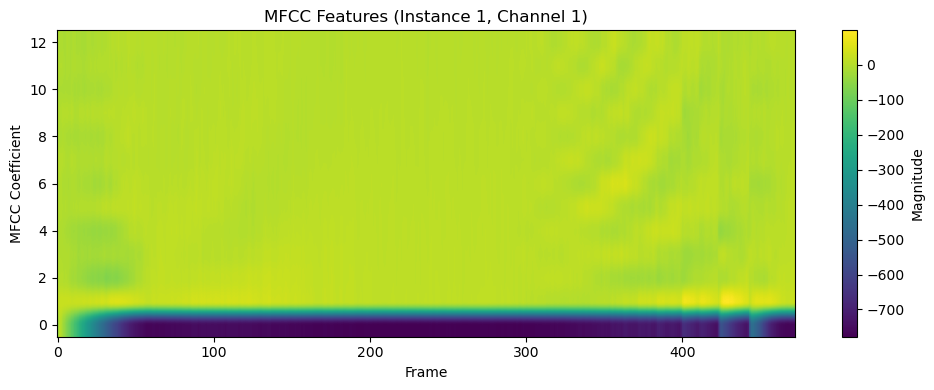

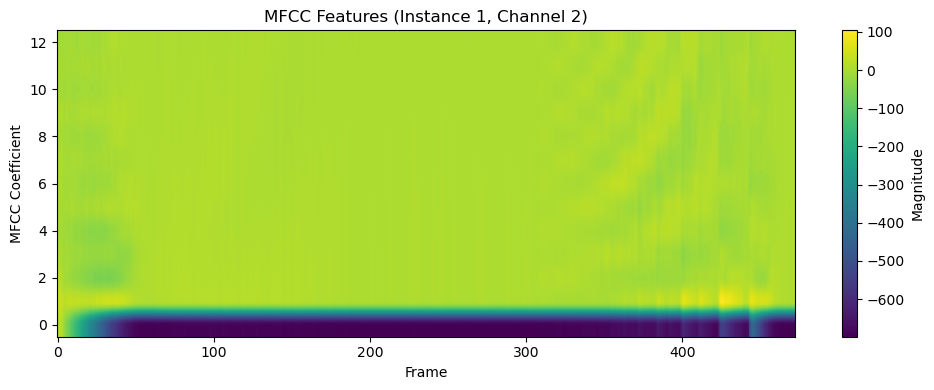

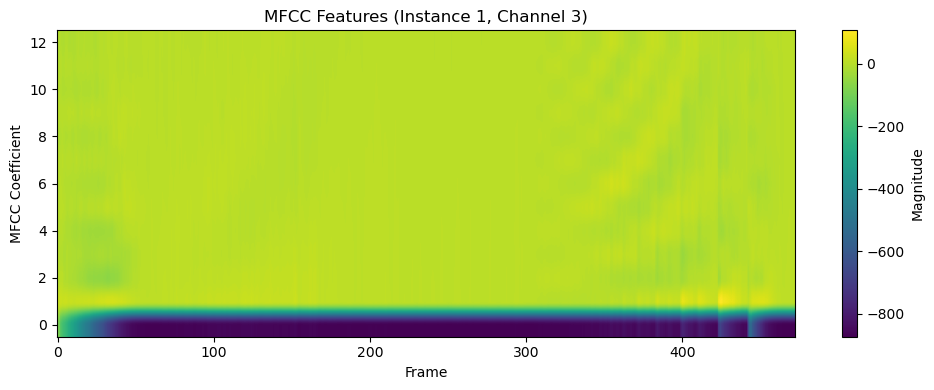

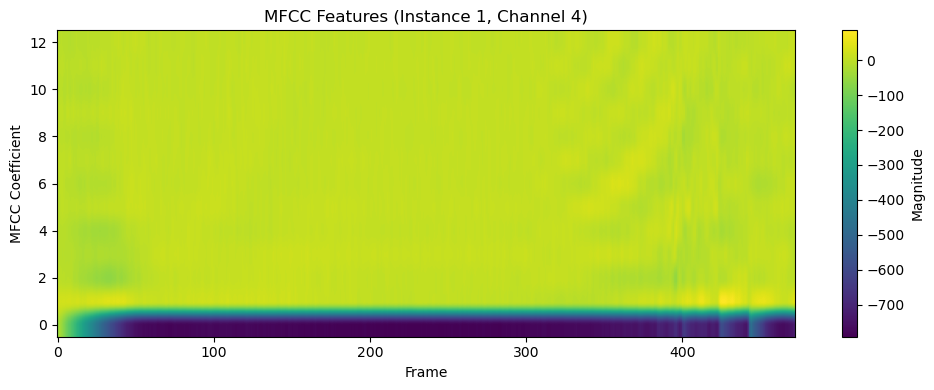

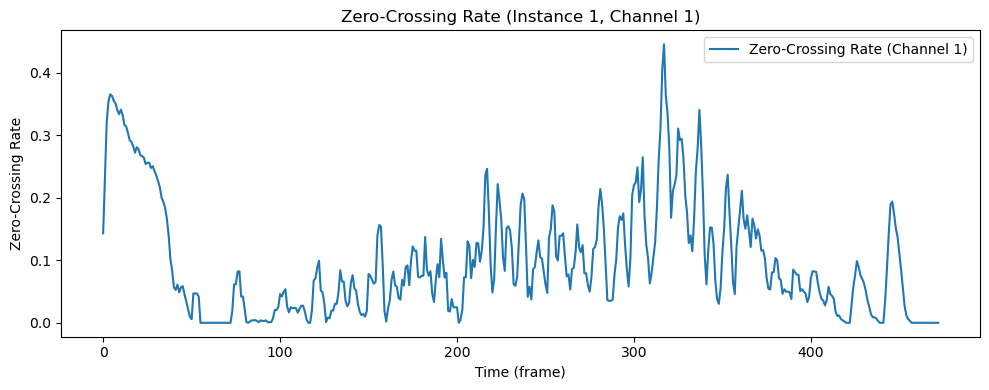

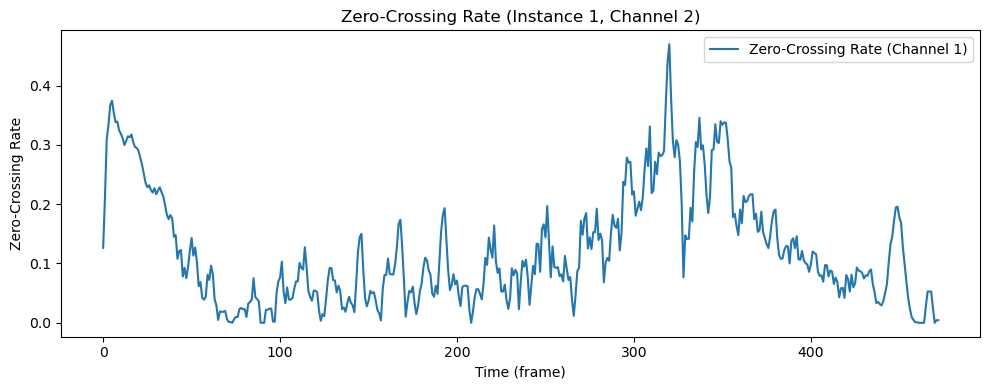

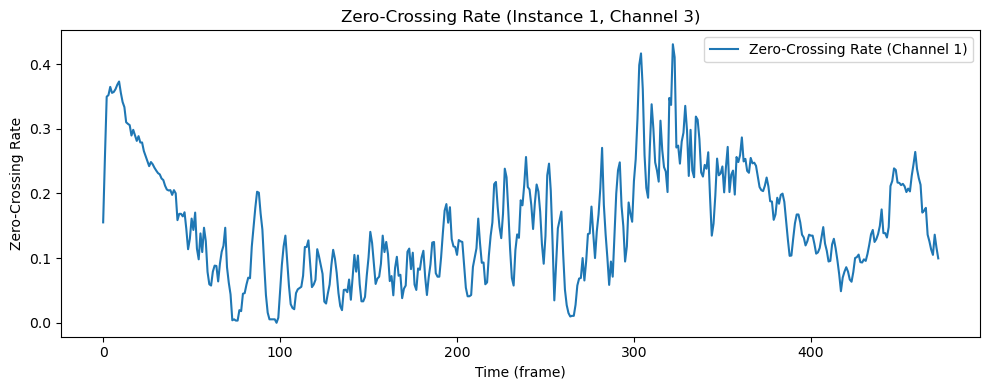

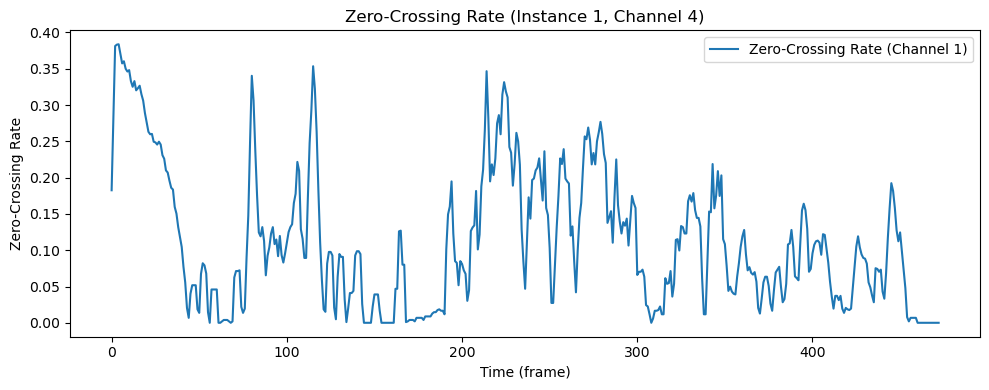

In [45]:
# Plot audio features for each instance and channel
#for instance_index in range(preprocessed_data_rms.shape[0]):
#    for channel_index in range(preprocessed_data_rms.shape[1]):
#        rms_features = preprocessed_data_rms[instance_index, channel_index]
#        plot_audio_features(rms_features=rms_features, instance_index=instance_index, channel_index=channel_index)
#    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_mfcc_h1.shape[0]):
    for channel_index in range(preprocessed_data_mfcc_h1.shape[1]):
        mfcc_features = preprocessed_data_mfcc_h1[instance_index, channel_index]
        plot_audio_features(mfcc_features=mfcc_features, instance_index=instance_index, channel_index=channel_index)
    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_zcr_h1.shape[0]):
    for channel_index in range(preprocessed_data_zcr_h1.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr_h1[instance_index, channel_index] 
        plot_audio_features(zero_crossing_rate=zero_crossing_rate, instance_index=instance_index, channel_index=channel_index)
    break

## Model

In [56]:
class CustomDataset(Dataset):
    def __init__(self, coordinates, preprocessed_data_mfcc=[], _type="rms", preprocessed_data_rms=[], preprocessed_data_zcr=[]):
        self.preprocessed_data_mfcc = preprocessed_data_mfcc
        self.preprocessed_data_rms = preprocessed_data_rms
        self.preprocessed_data_zcr = preprocessed_data_zcr
        self.coordinates = coordinates
        self.type = _type
        if self.type == "rms":
            print("RMS: ", preprocessed_data_rms.shape)
        elif self.type == "zcr":
            print("ZCR: ", preprocessed_data_zcr.shape)
        elif self.type == "mfcc":
            print("MFCC: ", preprocessed_data_mfcc.shape)
        
    def __len__(self):
        return len(self.coordinates)

    def __getitem__(self, idx):
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        if self.type == "rms":
            rms = self.preprocessed_data_rms[idx]
            rms = torch.tensor(rms, dtype=torch.float32)
            return np.array(rms), coordinates
        elif self.type == "mfcc":
            mfcc = [torch.tensor(self.preprocessed_data_mfcc[idx, mic_index], dtype=torch.float32) for mic_index in range(4)]
            return np.array(mfcc), coordinates
        elif self.type == "zcr":
            zcr = torch.tensor(self.preprocessed_data_zcr[idx], dtype=torch.float32) if self.preprocessed_data_zcr else None
            return np.array(zcr), coordinates
        else:
            print("Error type")
            return None, None

In [60]:
train_dataset = CustomDataset(coordinates=centroids_h1, preprocessed_data_mfcc=preprocessed_data_mfcc_h1, _type="mfcc" )
test_dataset = CustomDataset(coordinates=centroids_h2, preprocessed_data_mfcc=preprocessed_data_mfcc_h2, _type="mfcc")

MFCC:  (1000, 4, 13, 473)
MFCC:  (104, 4, 13, 473)


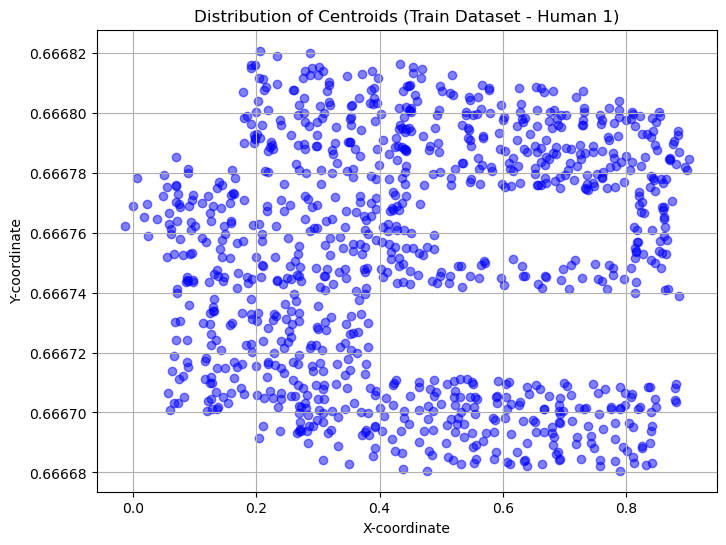

In [61]:
# Extract coordinates (centroids) from train dataset (Human 1)
train_coordinates = [train_dataset[i][1].numpy() for i in range(len(train_dataset))]
train_coordinates = np.array(train_coordinates)

# Plot distribution of centroids for train dataset
plt.figure(figsize=(8, 6))
plt.scatter(train_coordinates[:, 0], train_coordinates[:, 1], c='b', alpha=0.5)
plt.title("Distribution of Centroids (Train Dataset - Human 1)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True)
plt.show()

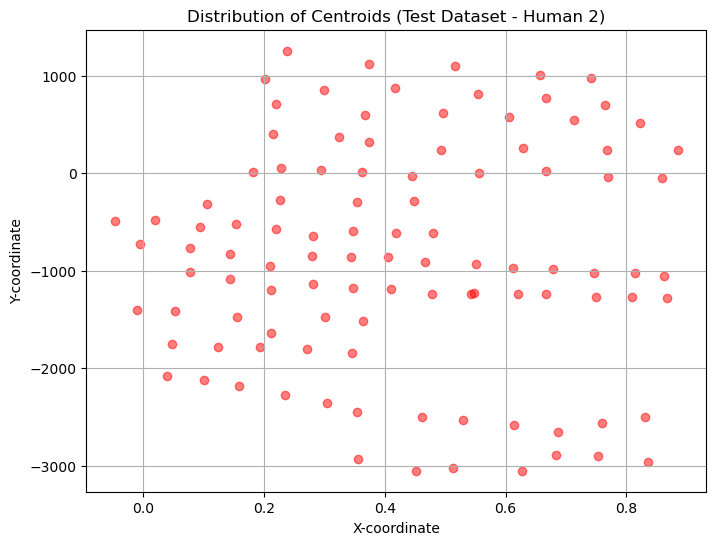

In [62]:
# Extract coordinates (centroids) from test dataset (Human 2)
test_coordinates = [test_dataset[i][1].numpy() for i in range(len(test_dataset))]
test_coordinates = np.array(test_coordinates)

# Plot distribution of centroids for test dataset
plt.figure(figsize=(8, 6))
plt.scatter(test_coordinates[:, 0], test_coordinates[:, 1], c='r', alpha=0.5)
plt.title("Distribution of Centroids (Test Dataset - Human 2)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True)
plt.show()


In [69]:
class SingleMicDataset(Dataset):
    def __init__(self, coordinates, mic_index, preprocessed_data_mfcc=None, preprocessed_data_rms=None, preprocessed_data_zcr=None):
        self.coordinates = coordinates
        self.mic_index = mic_index
        self.preprocessed_data_mfcc = preprocessed_data_mfcc
        self.preprocessed_data_rms = preprocessed_data_rms
        self.preprocessed_data_zcr = preprocessed_data_zcr
        
    def __len__(self):
        return len(self.coordinates)

    def __getitem__(self, idx):
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        if self.preprocessed_data_mfcc is not None:
            mfcc = torch.tensor(self.preprocessed_data_mfcc[idx, self.mic_index], dtype=torch.float32)
            print("MFCC: ", mfcc.shape)
            return mfcc, coordinates
        elif self.preprocessed_data_rms is not None:
            rms = torch.tensor(self.preprocessed_data_rms[idx, self.mic_index], dtype=torch.float32)
            return rms, coordinates
        elif self.preprocessed_data_zcr is not None:
            zcr = torch.tensor(self.preprocessed_data_zcr[idx, self.mic_index], dtype=torch.float32)
            return zcr, coordinates
        else:
            return None, coordinates


In [75]:
# Create datasets for each microphone channel (Human 1)
mic_datasets_h1 = []
for mic_index in range(4):
    # Create dataset for the specific microphone channel
    dataset = SingleMicDataset(coordinates_h1, mic_index, preprocessed_data_mfcc=preprocessed_data_mfcc_h1)
    mic_datasets_h1.append(dataset)

mic1 = mic_datasets_h1[0]
mfcc_features, coordinates = mic1[0]
print(mfcc_features)
# # Plot MFCC features for each microphone dataset (Human 1)
# mic_names = ['Microphone 1', 'Microphone 2', 'Microphone 3', 'Microphone 4']
# for mic_index in range(4):
#     print(f"Plotting MFCC features for {mic_names[mic_index]} Dataset (Human 1)")
#     dataset = mic_datasets_h1[mic_index]
#     for instance_index in range(min(3, len(dataset))):  # Plot up to 3 instances
#         mfcc_features, coordinates = dataset[instance_index]
#         # Plot MFCC features
#         plt.figure(figsize=(10, 4))
#         plt.imshow(mfcc_features, cmap='viridis', origin='lower', aspect='auto')
#         plt.colorbar(label='Magnitude')
#         plt.xlabel('Frame')
#         plt.ylabel('MFCC Coefficient')
#         plt.title(f'MFCC Features ({mic_names[mic_index]}) - Instance {instance_index + 1}')
#         plt.tight_layout()
#         plt.show()

MFCC:  torch.Size([13, 473])
tensor([[-5.7166e+01,  7.3963e+00,  3.7073e+00,  ..., -7.6400e+02,
         -7.6433e+02, -7.5176e+02],
        [ 8.8888e+00,  2.0729e+01,  2.7005e+01,  ...,  2.7108e+01,
          2.6383e+01,  4.0880e+01],
        [-8.7422e+00, -2.3136e+00,  4.5902e-01,  ...,  1.9389e+01,
          1.8968e+01,  2.7097e+01],
        ...,
        [-1.5046e+01, -1.2672e+01, -1.0575e+01,  ...,  2.8563e+00,
          4.6200e+00,  4.1622e+00],
        [-3.8388e+00, -4.3870e+00, -3.2439e+00,  ...,  3.0566e+00,
          5.6906e+00,  3.7922e+00],
        [-7.7496e+00, -8.2680e+00, -9.7775e+00,  ...,  3.9488e+00,
          6.5997e+00,  5.2013e+00]])


In [63]:
def euclidean_distance_loss(outputs, labels):
    # Calculate Euclidean distance (L2 norm) between predicted coordinates and labels
    distance = torch.norm(outputs - labels, p=2, dim=1)  # Compute L2 norm along dimension 1
    loss = torch.mean(distance)  # Calculate mean of distances
    return loss


In [64]:
# Define batch size
batch_size = 32

# Create data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [65]:
# Define the CNN model architecture
class MFCC_CNN(nn.Module):
    def __init__(self):
        super(MFCC_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 59 * 7, 128)
        self.fc2 = nn.Linear(128, 2)  # Output: 2 (coordinates)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 59 * 7)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model
model = MFCC_CNN()


In [66]:
import torch.optim as optim

# Define the optimizer and use the custom Euclidean distance loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with the custom loss function
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Use the MFCC features from the first microphone channel
        mfcc_features = inputs[:, 0, :, :].unsqueeze(1)  # Extract first mic and add channel dimension
        
        # Forward pass
        outputs = model(mfcc_features)
        
        # Calculate Euclidean distance loss
        loss = euclidean_distance_loss(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print epoch loss
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


RuntimeError: shape '[-1, 13216]' is invalid for input of size 362496